In [2]:
using Random
using Distributions
using RxInfer
using DataFrames
# using StatsPlots

In [3]:
Random.seed!(42)

## Simulate synthetic workers

In [480]:
# Parameters
num_workers = 5
num_projects = 30

# Define latent traits
traits = [:competence, :communication, :reliability, :creativity, :conflict]

# Generate true latent traits (hidden ground truth)
true_traits = Dict(trait => rand(Normal(0, sqrt(10)), num_workers) for trait in traits)

# Create project pairs
pairs = [(rand(1:num_workers), rand(1:num_workers)) for _ in 1:num_projects]
pairs = [(i != j ? (i, j) : (i, rand(filter(x -> x != i, 1:num_workers)))) for (i, j) in pairs]

# Generate observed collaboration scores
function generate_collaboration_score(i, j)
    combined_score =
          0.3 * (true_traits[:competence][i] + true_traits[:competence][j]) / 2
        + 0.3 * (true_traits[:communication][i] + true_traits[:communication][j]) / 2
        + 0.2 * (true_traits[:reliability][i] + true_traits[:reliability][j]) / 2
        + 0.1 * (true_traits[:creativity][i] + true_traits[:creativity][j]) / 2
        - 0.2 * (true_traits[:conflict][i] + true_traits[:conflict][j]) / 2
    
    combined_score += rand(Normal(0, 1.0)) # Add noise
    return clamp(combined_score, 0.0, 1.0)
end

observed_scores = [generate_collaboration_score(i, j) for (i, j) in pairs];

In [616]:
my_clamp(x₁, x₂, x₃, x₄, x₅) = 1/(1 + exp(-x₁ - x₂ - x₃ - x₄ - x₅))

my_clamp (generic function with 1 method)

## Define Model

In [633]:
@model function CollaborationModel(observed_scores, pairs, num_workers)

    local competence, communication, reliability, creativity, conflict
    # Latent traits per worker
    for i in 1:num_workers
        competence[i] ~ Normal(mean=0.0, var=10.0)
        communication[i] ~ Normal(mean=0.0, var=10.0)
        reliability[i] ~ Normal(mean=0.0, var=10.0)
        creativity[i] ~ Normal(mean=0.0, var=10.0)
        conflict[i] ~ Normal(mean=0.0, var=10.0)
    end

    # Observations
    for n in 1:length(observed_scores)
        wi, wj = pairs[n]

        competence_score[n]    := competence[wi] + competence[wj]
        communication_score[n] := communication[wi] + communication[wj]
        reliability_score[n]   := reliability[wi] + reliability[wj]
        creativity_score[n]    := creativity[wi] + creativity[wj]
        conflict_score[n]      := conflict[wi] + conflict[wj]


        observed_scores[n] ~ Normal(mean=my_clamp(0.15*competence_score[n], 0.15*communication_score[n], 0.1*reliability_score[n],0.05*creativity_score[n], 0.1*conflict_score[n]), var=0.01)
    end
end

In [634]:
init = @initialization begin 
    μ(competence) = vague(NormalMeanVariance)
    μ(communication) = vague(NormalMeanVariance)
    μ(reliability) = vague(NormalMeanVariance)
    μ(creativity) = vague(NormalMeanVariance)
    μ(conflict) = vague(NormalMeanVariance)
end

Initial state: 
  μ(competence) = NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)
  μ(communication) = NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)
  μ(reliability) = NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)
  μ(creativity) = NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)
  μ(conflict) = NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)


In [650]:
meta = @meta begin
    my_clamp() -> Linearization()
end

Meta: 
  my_clamp() -> Linearization()


In [664]:
# Run inference
result = infer(model=CollaborationModel(pairs=pairs, num_workers=num_workers), data=(observed_scores=observed_scores,), initialization=init, meta=meta, free_energy=true, iterations=5);

In [665]:
using Plots

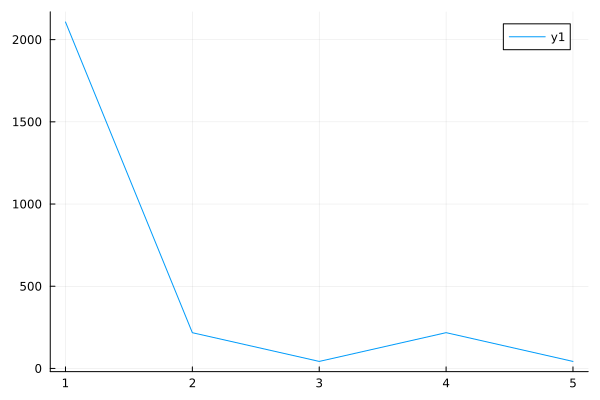

In [666]:
plot(result.free_energy)

In [667]:
mean.(result.posteriors[:communication][end])

5-element Vector{Float64}:
 -1.3578045547911732
  1.9880407491994345
  0.12946927597687982
  1.9859609935452378
 -1.2386156255675178

In [668]:
true_traits[:communication]

5-element Vector{Float64}:
 -1.241211186656285
 -1.8469781088823325
 -1.0590715752872972
  3.5767728393345006
 -1.6733147625388274

In [669]:
mean.(result.posteriors[:reliability][end])

5-element Vector{Float64}:
 -0.9043046070749982
  1.3253621352766711
  0.09376432739645779
  1.3239764474293292
 -0.8142774895048156

In [670]:
true_traits[:reliability]

5-element Vector{Float64}:
  3.784793490367347
 -1.5359343270679813
 -6.045003478809501
 -0.41540528107797503
  0.18562246596228169

In [671]:
mean.(result.posteriors[:creativity][end])

5-element Vector{Float64}:
 -0.4515423935093709
  0.6626821567002915
  0.05028664647900097
  0.661989776861997
 -0.40038108260563365

In [672]:
true_traits[:creativity]

5-element Vector{Float64}:
 -2.597075000609554
 -4.429166106627935
 -2.8597616982766603
  3.181914451667847
  0.8367395827325114

In [673]:
mean.(result.posteriors[:competence][end])

5-element Vector{Float64}:
 -1.3578045547911732
  1.9880407491994345
  0.12946927597687982
  1.9859609935452378
 -1.2386156255675178

In [674]:
true_traits[:competence]

5-element Vector{Float64}:
 -4.479898706798737
 -3.509163299310949
 -2.6795113335286906
 -5.033686548558048
  2.313282032100281

In [677]:
mean.(result.posteriors[:conflict][end])

5-element Vector{Float64}:
 3.0552025506650162
 3.0557726189978602
 3.15711594702893
 3.0557725562594706
 3.0509977659095053

In [676]:
true_traits[:conflict]

5-element Vector{Float64}:
 -0.6902735015754795
 -4.6045372453202615
  2.4739097060846236
 -1.817732828066478
  1.3277498548011173